# Public bicycles in Barcelona

Brief study of the public bicycle rental service in the city of Barcelona [Bicing](https://www.bicing.barcelona/es).

Juan G. Marinero Tarazona

<img align="center" style="width:400px;padding-right:15px;" src="https://www.bicing.barcelona/sites/default/files/2019-01/est.JPG" caption="aaa">

## Index
1. [Barcelona city council dataset](#Barcelona-city-council-dataset)
1. [Bicing park station sizes](#Bicing-park-station-sizes)
1. [Graphical initial approximation](#Graphical-initial-approximation)
1. [Add variables](#Add-variables)
1. [Eigenvectors](#Eigenvectors)
1. [Study of a specific parking lot](#Study-of-a-specific-parking-lot)

In [1]:
import pandas as pd
import numpy as np

from IPython.display import display_html
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

from data.data import get_data
from data.weather import get_weather

from data.add_holidays import add_holidays
from data.dataConstructor import dataConstructor

from ML_fcns.cumuExplVariance import cumuExplVariance
from ML_fcns.PCA_LinearRegression import PCA_LinearRegression
from ML_fcns.PCA_plot import PCA_plot
from ML_fcns.first_Python_list_index_greater_than_x import first_Python_list_index_greater_than_x

In [2]:
# https://support.enthought.com/hc/en-us/articles/204469240-Jupyter-IPython-After-editing-a-module-changes-are-not-effective-without-kernel-restart
%load_ext autoreload
%autoreload 2

## Barcelona city council dataset

From [Open Data BCN](http://opendata-ajuntament.barcelona.cat/es/) (Open data service of the Barcelona City Council) we downloaded the dataset [Bicing stations of the city of Barcelona (Mechanics and electrics)](https://opendata-ajuntament.barcelona.cat/data/en/dataset?q=bicing&sort=fecha_publicacion+asc) for the month December 2018.

<img align="center" style="width:900px;padding-right:15px;" src="./open_data_bcn_bicing_01.png" caption="aaa">

In [3]:
data = get_data()
data.head()

,id,type,latitude,longitude,streetName,streetNumber,altitude,slots,bikes,nearbyStations,status
updateTime,,,,,,,,,,,
2018-11-30 23:59:14,1,BIKE,41.397952,2.180042,Gran Via Corts Catalanes,760,21,10,17,"24, 369, 387, 426",OPN
2018-11-30 23:59:14,2,BIKE,41.395530,2.177060,Roger de Flor/ Gran Vía,126,21,4,23,"360, 368, 387, 414",OPN
2018-11-30 23:59:14,3,BIKE,41.394055,2.181299,Nàpols,82,22,9,18,"4, 6, 119, 419",OPN
2018-11-30 23:59:14,4,BIKE,41.393480,2.181555,Ribes,13,21,0,20,"3, 5, 359, 419",OPN
2018-11-30 23:59:14,5,BIKE,41.391075,2.180223,Pg Lluís Companys,11,16,1,38,"6, 7, 359, 418",OPN


Check for missing data (NaN).

In [4]:
print(f"Are there NaN values?: {data.isnull().values.any()}")

Are there NaN values?: False


We have about 3.8 million samples

In [5]:
f'{data.shape[0]:.2g}'

'3.8e+06'

Corresponding to 463 different locations

In [6]:
len(set(data.id))

463

As the name of the dataset indicated, bicycles are classified as mechanical (``BIKE``) and electric (``BIKE-ELECTRIC``).

In [7]:
set(data.type)

{'BIKE', 'BIKE-ELECTRIC'}

Each bike station can be operational (``OPN``) or closed (``CLS``).

In [8]:
set(data.status)

{'CLS', 'OPN'}

## Bicing park station sizes

Size of each bike rack is the sum of bikes parked (column $bikes$) plus the empty slots for bikes (column $slots$).

In [9]:
df = data.copy()
df["rackSize"] = data["bikes"] + data["slots"]
df = df.loc[data['status']=='OPN']

### Parking sizes

Each bicycle parking has a dynamic size.

Each bicing parking can be enlarged or reduced according to demands. For example, the ones close to beach are more demanded on weekends, and therefore should offer more bikes than on working days.

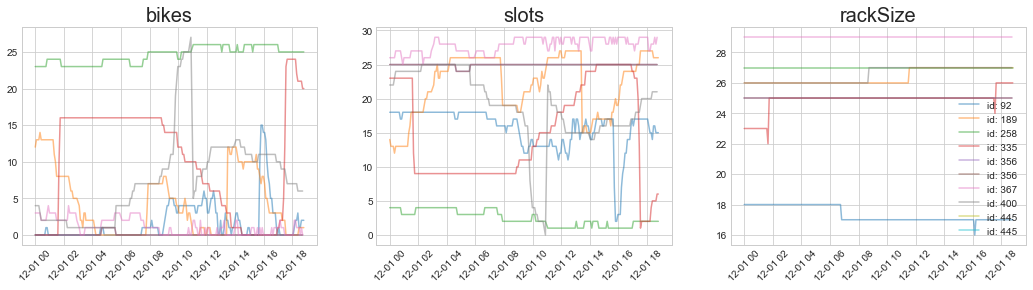

In [10]:
def plot_feature_each_id(df, feature, id_range=[], ax=None, legend_bool=False):
    feature = df[feature]
    if not len(id_range): id_range=set(df['id'])
        
    #fig01 = plt.figure(figsize=(6, 6))
    legend_arr = []
    for k in id_range:
        pass
        mask = (df['id'] == k)
        ax.plot(feature[mask], alpha=.5)
        legend_arr.append(f"id: {k}")
    if legend_bool: ax.legend(legend_arr)
    return ax

feature_arr = ['bikes', 'slots', 'rackSize']
id_range= np.random.randint(len(set(data.id)), size=(10,))
n = len(feature_arr)
fig, ax = plt.subplots(1, n,  figsize=(n*6,4));
for i,k in enumerate(feature_arr):
    plot_feature_each_id(df[:100000], k, np.sort(id_range), ax[i], legend_bool=(i+1==n))
    ax[i].set_title(k, fontsize=20)
    ax[i].tick_params(axis='x', labelrotation=45)

So, if we want to classify bicing parkings by size, we might select its average capacity (rackSize), but that would be too imprecise, because, as next plot shows, almost every bicycle parking has a great diversity of sizes.

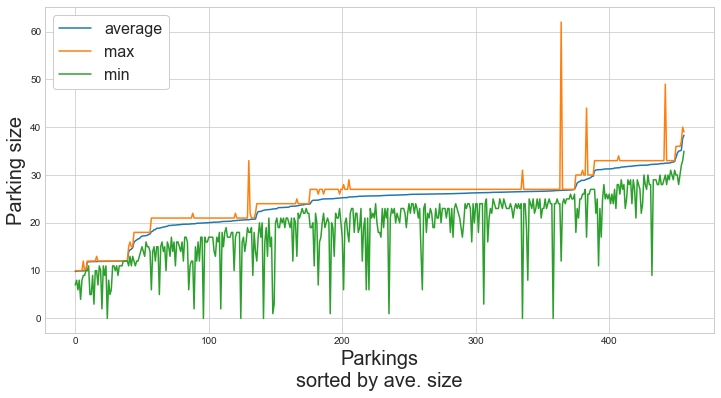

In [11]:
rackSizeMean = df.groupby('id')['rackSize'].mean().sort_values()

plt.figure(figsize=(12, 6))

plt.plot(rackSizeMean.values, label='average')
plt.plot(df.groupby('id')['rackSize'].max()[rackSizeMean.index].values, label='max')
plt.plot(df.groupby('id')['rackSize'].min()[rackSizeMean.index].values, label='min')

plt.xlabel('Parkings\nsorted by ave. size', fontsize=20);
plt.ylabel('Parking size', fontsize=20);
plt.legend(framealpha=1, frameon=True, fontsize=16);

To quantify that big fluctuationg, next shows how this variation is little correlated to the size of the parking lot.

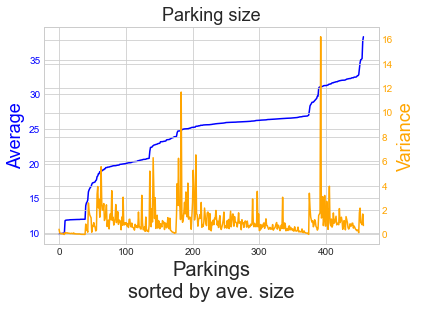

In [12]:
fig, ax1 = plt.subplots()
colors = ["blue", "orange"]

plt.title("Parking size", fontsize=18)
plt.xlabel('Parkings\nsorted by ave. size', fontsize=20);

ax1.plot(rackSizeMean.values, color=colors[0])
ax1.set_ylabel(r"Average", fontsize=18, color=colors[0])
for label in ax1.get_yticklabels():
    label.set_color(colors[0])

aux = df.groupby('id')['rackSize'].var()[rackSizeMean.index]
ax2 = ax1.twinx()
ax2.plot(df.groupby('id')['rackSize'].var()[rackSizeMean.index].values, color=colors[1])
ax2.set_ylabel(r"Variance", fontsize=18, color=colors[1])
for label in ax2.get_yticklabels():
    label.set_color(colors[1]);

## Graphical initial approximation

What is the amount of rented bicycles at each moment?

Graph to corroborate whether the day of the week and its holiday influence the amount of bicycles.

In [13]:
# data = get_data()
df_day = pd.DataFrame(data["bikes"][data["status"]=='OPN'].resample('D').sum()[1:-1])

df_day['day_of_week'] = df_day.index.day_name()
df_day = df_day.join(pd.get_dummies(df_day['day_of_week'] ))

df_day = add_holidays(pd.DataFrame(df_day));

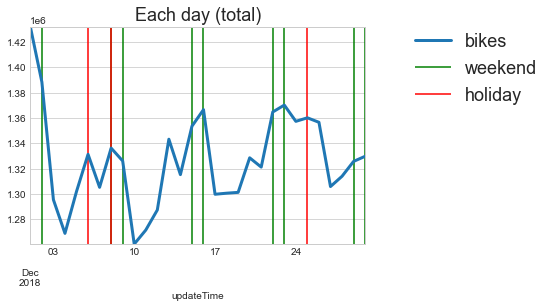

In [14]:
fig, ax = plt.subplots()
maxVal = max(df_day['bikes'])
df_day[['bikes']].plot(ax = ax, linewidth=3)
ax.vlines(x=df_day.index[(df_day['Saturday']==1) | (df_day['Sunday']==1)], ymin=0, ymax=maxVal, label='weekend', color='g')
ax.vlines(x=df_day.index[df_day['holiday']==1], ymin=0, ymax=maxVal, label='holiday', color='r')

ax.set_ylim(min(df_day['bikes']),maxVal);
ax.set_title('Each day (total)', fontsize=18);
ax.legend(bbox_to_anchor=(1.1, 1.05), fontsize=18);

Timerange is not wide, but given that the number of different locations is considerable (463), it is not very daring to assume, thanks to the previous plot, that: there are more bicycles for rent on non-working days, and the days that more they use are Monday and Tuesday.

We can also assume that more bikes can be rented ($bike$ column of $data$) when most people have already reached their destination (work, home, park, etc.), that is, mid-morning, at lunchtime, in the evening, etc.

A study of whole week shows little trends:

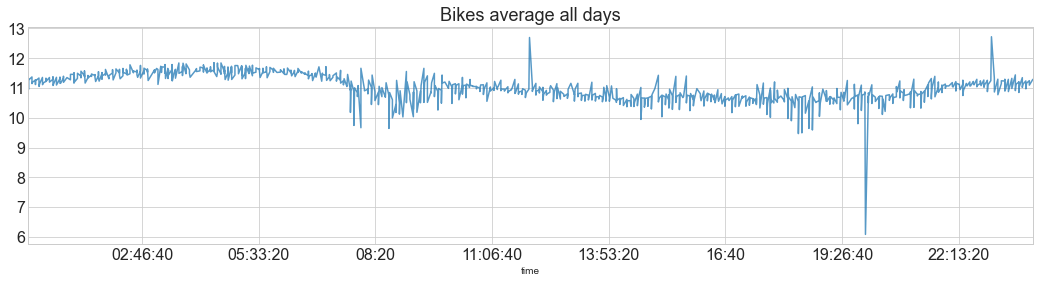

In [15]:
ax = df['bikes'].groupby(df.index.time).mean()[1:-1].plot(fontsize=16, figsize=(18,4), alpha=.75);
ax.set_title('Bikes average all days', fontsize=18);
ax.set_xlim([min(df.index.time),max(df.index.time)])
ax.locator_params(nbins=10, axis='x')

Studying the weekdays separately:

In [16]:
# data = get_data()
df_hour = pd.DataFrame(data["bikes"][data["status"]=='OPN'].resample('H').mean()[1:-1])

df_hour['day_of_week'] = df_hour.index.day_name()
df_hour = df_hour.join(pd.get_dummies(df_hour['day_of_week'] ))

df_hour = add_holidays(pd.DataFrame(df_hour));

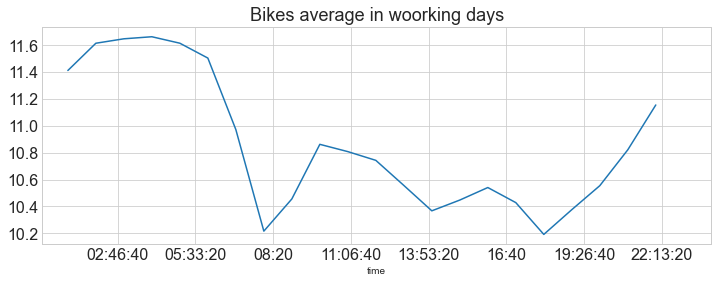

In [17]:
df_hour_workday = df_hour[(df_hour['Saturday']!=1) & (df_hour['Sunday']!=1) & (df_hour['holiday']!=1)]
ax = df_hour_workday['bikes'].groupby(df_hour_workday.index.time).mean()[1:-1].plot(fontsize=16, figsize=(12,4));
ax.set_title('Bikes average in woorking days', fontsize=18);
ax.set_xlim([min(df.index.time),max(df.index.time)])
ax.locator_params(nbins=10, axis='x')

It is observed that approximately:
- from 6 to 8 in the morning many bikes are rented (in itinere)
- from 8 a.m. to 10 a.m. many of the bikes are returned (in itinere)
- From 18 to 1 in the morning, more and more bikes are parked instead of rented (leisure or split-day itinere)

## Add variables

We add weather variables, holidays and days of the week

In ``get_weather()`` we have selected a series of quantitative variables (such as relative humidity and temperature) and a categorical variable (LabelEncoders) to determine the rain or fog ($Light\,drizzle$, $Light\,rain$, $Mist$ y $No\,rain$).

In [18]:
w = get_weather()
w.head()

,°C,Humidity (%),Wind (m/s),Clouds,Visibility,Light drizzle,Light rain,Mist,No rain
Local time in Barcelona (airport),,,,,,,,,
2018-12-31 23:30:00,9,54,7,0,10,0,0,0,1
2018-12-31 23:00:00,10,50,7,0,10,0,0,0,1
2018-12-31 22:30:00,10,50,6,0,10,0,0,0,1
2018-12-31 22:00:00,11,47,5,0,10,0,0,0,1
2018-12-31 21:30:00,11,50,5,0,10,0,0,0,1


This climatological dataFrame, along with another for holidays ($holidays$) and another for hours of daily light, are merged with the initial bicing table $ data $.

In  $data$ the variables of interest are filtered and LabelEncoders of the categorical variables (such as status) are applied, as well as ``pd.get_dummies()`` to the day of the week.

We remove the (temporary) index from this large dataFrame and divide into the $y$ matrix corresponding to the column that we want to make predictions ($bike$) and the rest to matrix $X$.

In [19]:
#data = get_data();
Xy = dataConstructor(data.copy(),w); # pass copy to NOT modify original

ybar = ["bikes"]

XdC = Xy.drop(columns=ybar)
ydC = Xy[ybar]

The features are:

In [20]:
XdC.columns

Index(['id', 'altitude', 'slots', 'holiday', 'daylight_hrs', '°C',
       'Humidity (%)', 'Wind (m/s)', 'Clouds', 'Visibility', 'Light drizzle',
       'Light rain', 'Mist', 'No rain', 'hour', 'status', 'type', 'Friday',
       'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')

And the $X$ and $y$ are:

In [21]:
rows = 10;
styles = [dict(selector="th", props=[("font-size", "67%"), ("text-align", "center")])]
df1_styler = XdC.iloc[:rows,:].style.set_table_styles(styles).set_properties(**{"font-size": "80%"}).set_table_attributes("style='display:inline'").set_caption('X dataConstructor')\
             .background_gradient(subset=['slots'],cmap='Greens').hide_index()
df2_styler = pd.DataFrame(ydC.iloc[:rows]).style.set_table_styles(styles).set_properties(**{"font-size": "80%"}).set_table_attributes("style='display:inline'").set_caption('y').hide_index()
display_html(df2_styler._repr_html_() + 2*'&nbsp' + df1_styler._repr_html_(), raw=True)

bikes
17
23
18
20
38
38
26
26
27
20


# Eigenvectors

We select random rows, because 91 millions values are too much for my computer.

In [22]:
X = XdC.values
y = ydC.values
f"{XdC.size:.1e}, {XdC.shape}"

'9.1e+07, (3784760, 24)'

I reduce it to 1e5 rows aprox.

In [23]:
p = 1e5/XdC.shape[0] # just 1e5 rows
mask_reduce = np.random.choice(a=[False, True], size=(XdC.shape[0], 1), p=[1-p, p])
Xy_masked = Xy.copy()[mask_reduce]

In [24]:
Xy_masked.shape

(99633, 25)

$id$ is an identificator, not a variable.

In [25]:
XdC = Xy_masked.drop(columns=ybar).drop("id",1)
ydC = Xy_masked[ybar]

X = XdC.values
y = ydC.values
f"{XdC.size:.1e}, {XdC.shape}"

'2.3e+06, (99633, 23)'

With 3-dimensional eigenvectors we manage to describe 95% of covariance, and with 4, almost 100%:

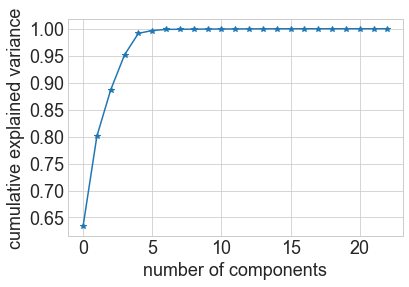

In [26]:
cumuExplVariance(X);

We estimate the total data (all bike parks) from the eigenvectors, applying a linear regression without regularization:

``PCA_LinearRegression()`` is made with the eigenvectors obtained with ``n_components``. Summary of it:

In [27]:
if False:
    
    from sklearn.decomposition import PCA
    from sklearn.linear_model import LinearRegression
    
    def PCA_LinearRegression(XdC, ydC, n_components, index):
        ...
        
        X = XdC.values
        y = ydC.values
                                                     
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X)
                                                     
        model = LinearRegression(fit_intercept=True)
        model.fit(X_pca, y)
        y_predicted = model.predict(X_pca)
        
        ...

,altitude,slots,holiday,daylight_hrs,°C,Humidity (%),Wind (m/s),Clouds,Visibility,Light drizzle,Light rain,Mist,No rain,hour,status,type,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
PC-0,1e+00,1e-01,2e-05,2e-05,1e-04,6e-04,6e-05,8e-04,1e-05,2e-06,1e-05,2e-06,1e-05,2e-04,2e-04,4e-05,2e-05,6e-05,8e-05,2e-05,4e-05,5e-05,3e-05
PC-1,2e-03,8e-03,3e-03,5e-04,5e-02,4e-01,2e-02,9e-01,1e-02,3e-04,8e-04,4e-04,2e-03,6e-02,3e-05,6e-05,8e-04,7e-03,2e-03,4e-03,3e-03,4e-03,5e-03
PC-2,1e-02,8e-02,6e-04,6e-04,2e-01,8e-01,3e-02,4e-01,1e-02,4e-04,9e-04,4e-04,2e-03,3e-01,1e-04,5e-04,5e-03,5e-03,5e-04,2e-03,8e-04,2e-03,1e-03
PC-3,1e-01,1e+00,5e-04,2e-04,9e-03,8e-02,1e-03,3e-02,2e-03,1e-05,1e-04,1e-04,2e-04,2e-03,2e-03,9e-03,6e-04,3e-04,8e-04,1e-03,3e-04,6e-04,8e-04


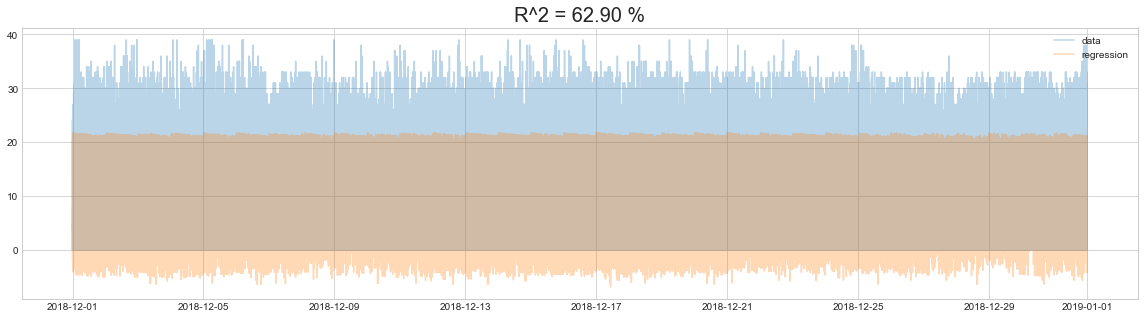

In [28]:
PCA_LinearRegression(XdC, ydC, 4, data[mask_reduce].index);

A poor coef. of determination $R^2$ around 65%. Maybe better study just a single park station.

## Study of a specific parking lot

In [29]:
def mask_id_fcn(data, Xy, mask_reduce, park_station=-1):
    if park_station == (-1):
        park_station = np.random.randint(len(set(data['id'])), size=(1,))[0]
    mask_id = (data['id'] == park_station)
    
    mask = np.multiply(mask_reduce.ravel(), mask_id.ravel())
    
    # note "altitude" is unneeded, since the parking station altitude is constant (like latitude and longitude)
    XdC = Xy[mask].drop(columns=ybar).drop("id",1).drop("altitude",1)
    ydC = Xy[mask][ybar]
    
    X = XdC.values
    y = ydC.values
    
    return (mask, XdC, ydC, X, y)

For a random park station:

In [30]:
mask, XdC, ydC, X, y = mask_id_fcn(data, Xy, mask_reduce)
f"{XdC.size:.1e}, {XdC.shape}"

'5.3e+03, (243, 22)'

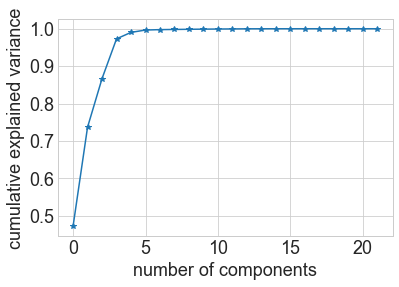

In [31]:
explained_variance_ratio__cum = cumuExplVariance(X);

In [32]:
v_min=0.9
(index, n_components) = first_Python_list_index_greater_than_x(explained_variance_ratio__cum, v_min=v_min)
print(f"Needed {n_components} variables to get a cumulate varianze of {v_min*100}%")

Needed 4 variables to get a cumulate varianze of 90.0%


The same number of eigenvectors are used in the linear regression:

,slots,holiday,daylight_hrs,°C,Humidity (%),Wind (m/s),Clouds,Visibility,Light drizzle,Light rain,Mist,No rain,hour,status,type,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
PC-0,2e-01,3e-03,8e-04,8e-02,5e-01,3e-02,8e-01,2e-02,4e-28,2e-04,1e-03,2e-03,8e-02,0e+00,0e+00,2e-03,8e-03,3e-03,4e-03,4e-03,5e-03,7e-03
PC-1,2e-01,1e-03,4e-04,2e-01,7e-01,5e-02,6e-01,6e-03,0e+00,1e-04,8e-04,7e-04,3e-01,0e+00,0e+00,4e-03,4e-03,2e-03,1e-03,1e-03,2e-03,4e-04
PC-2,9e-01,4e-03,4e-05,4e-02,1e-01,5e-02,8e-02,2e-03,0e+00,1e-03,1e-03,1e-05,4e-01,0e+00,0e+00,2e-03,4e-03,1e-03,4e-03,4e-03,4e-03,5e-04
PC-3,4e-01,2e-03,2e-04,1e-01,4e-01,1e-01,7e-02,3e-02,7e-24,9e-04,4e-03,5e-03,8e-01,0e+00,0e+00,5e-03,1e-02,2e-03,6e-03,6e-03,7e-05,8e-03


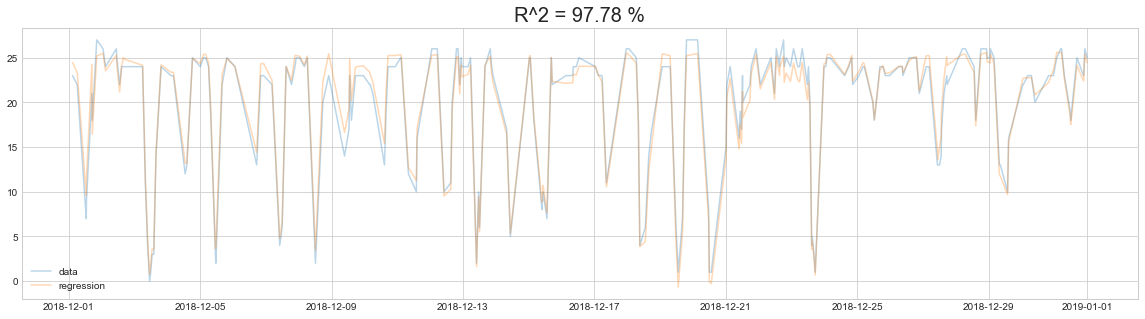

In [33]:
PCA_LinearRegression(XdC, ydC, n_components, data[mask].index);

While 2 eigenvectors would be way too short.

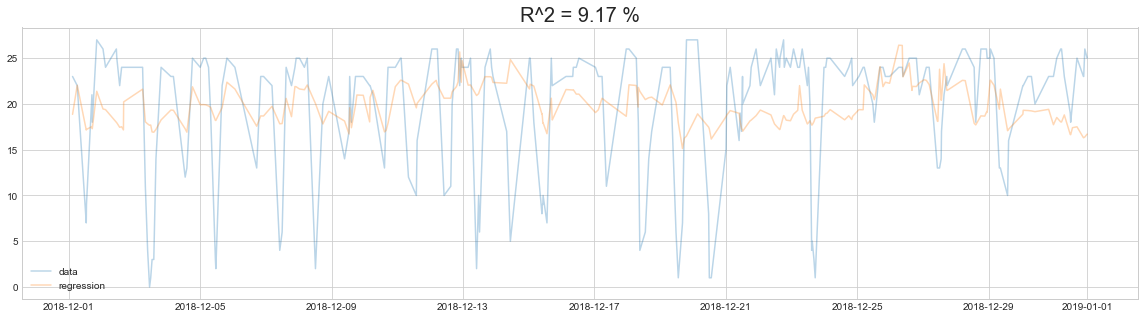

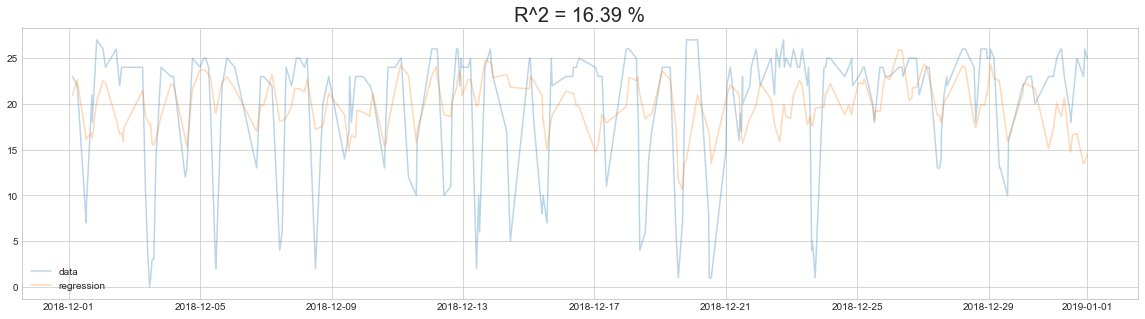

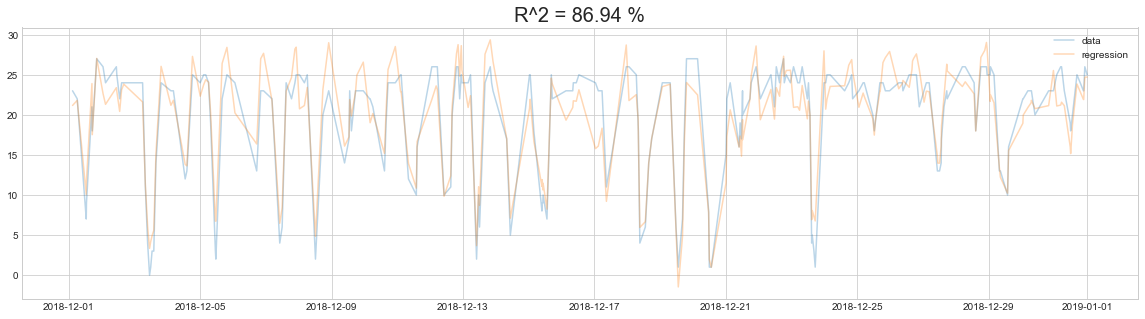

In [34]:
for k in list(range(n_components-1)):
    PCA_LinearRegression(XdC, ydC, k+1, data[mask].index, display_table_bool=False);

Recalling the meaning of the vectors returned by PCA, I quote [behzad.nouri](https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn/22986100#22986100):


Each principal component is a linear combination of the original variables:
$$PC^j \,=\,\beta_1^j\,X_1 \,+\, \beta_2^j\,X_2 \,+\, \cdots \,+\, \beta_n^j\,X_n$$
where $X_i$-s are the original variables, and $\beta_i$-s are the corresponding weights or so called coefficients.

Therefore, studying the ``pca.components_``:

- ``humidity`` and  ``clouds``: eigenvector ``PC-0`` it is formed by a combination of the original variables where these are the one that applies the greatest weight (the variable with the greatest variance).
- ``slots``: acquires great weight as seen in ``PC-1`` and ``PC-2``
- ``hour`` and  ``ºC`` (temperature) are next in important variation

We shall anyway clean data: feature engineering must be applied to PCA, for example customizing the method with outlier filter.

Aim of PCA - [link](https://stackoverflow.com/a/42867972/9391770)
>PCA, as I understand it, identifies the features with the greatest variance in a dataset, and can then use this quality of the dataset to create a smaller dataset with a minimal loss of descriptive power. The advantages of a smaller dataset is that it It requires less processing power and should have less noise in the data. But the features of greatest variance are not the "best" or "most important" features of a dataset, insofar as such concepts can be said to exist at all.

Summary:

- PCA provides the eigenvectors, which are a combination of the original variables with greater weight, those that have greater variance

- Not because a variable (a column of matrix $X$) has greater variance, it implies that it is more important to estimate the column $y$.

- PCA works very well in linear relationships, but not others (exponential, sinusoidal, ...)

Let's check if all coef. of determination $R^2$  are so good.

In [35]:
def R2_study(data, data_id_set=[], v_min_PCA=90, v_min_R2=95, iterate_bool=True):
    v_min_PCA /= 100
    if not len(data_id_set):
        data_id_set = np.sort(list(set(data['id']))) # might be not complete because we purged rows ramdomly
    n = len(data_id_set)
    R2 = np.zeros(n)
    n_components_PCA = R2.copy()
    n_components_R2 = R2.copy()
    for i,k in enumerate(data_id_set):
        # print(k)
        mask, XdC, ydC, X, y = mask_id_fcn(data, Xy, mask_reduce, k)
        explained_variance_ratio__cum = cumuExplVariance(X, plot_bool=False)
        (_ , n_components_PCA[i]) = first_Python_list_index_greater_than_x(explained_variance_ratio__cum, v_min=v_min_PCA)
        if n_components_PCA[i] == None: # if list has not element >= v_min
            n_components_PCA[i] = -1
        if np.sum(y): # if there is always 0 bikes, regression crashes
            if iterate_bool:
                while (R2[i] < v_min_R2) & (n_components_R2[i] < X.shape[1]):
                    n_components_R2[i] += 1
                    R2[i] = PCA_LinearRegression(XdC, ydC, np.int(n_components_R2[i]), data[mask].index, just_coef_determination=True)
            else:
                n_components_R2[i] = n_components_PCA[i]
                R2[i] = PCA_LinearRegression(XdC, ydC, np.int(n_components_R2[i]), data[mask].index, just_coef_determination=False)
    return (R2, n_components_PCA, n_components_R2)

In [36]:
v_min_PCA = 90
v_min_R2 = 95
R2, n_components_PCA, n_components_R2 = R2_study(data, v_min_PCA=v_min_PCA, v_min_R2=v_min_R2);

In [37]:
data_id_set = np.sort(list(set(data['id'])))

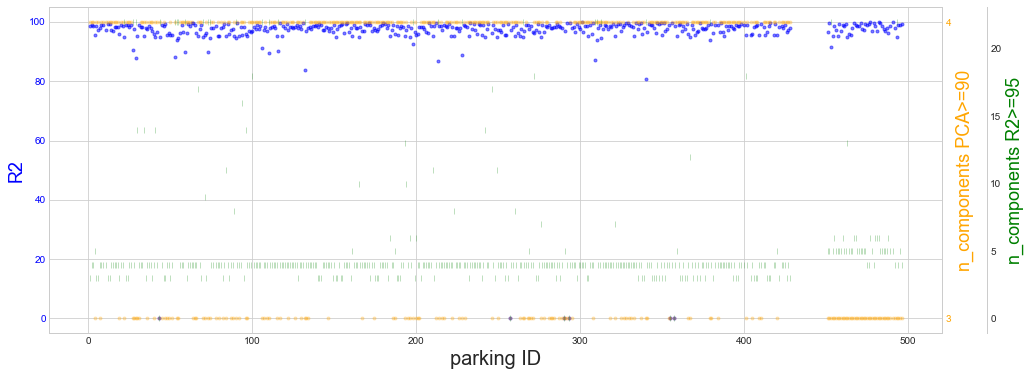

In [38]:
fig, ax1 = plt.subplots(figsize=(16,6))
colors = ["blue", "orange", "green"]

plt.xlabel('parking ID', fontsize=20);

ax1.plot(data_id_set,R2, '.', color=colors[0], alpha=.5)
ax1.set_ylabel(r"R2", fontsize=18, color=colors[0])
for label in ax1.get_yticklabels():
    label.set_color(colors[0])

ax2 = ax1.twinx()
ax2.plot(data_id_set,n_components_PCA, '.', color=colors[1], alpha=.25)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.05))
ax3.spines["right"].set_visible(True)
ax3.plot(data_id_set,n_components_R2, '|', color=colors[2], alpha=.25)
ax2.grid(False)
ax3.grid(False)
from matplotlib.ticker import MaxNLocator
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_ylabel(f"n_components PCA>={v_min_PCA}", fontsize=18, color=colors[1])
ax3.set_ylabel(f"n_components R2>={v_min_R2}", fontsize=18, color=colors[2])
for label in ax2.get_yticklabels():
    label.set_color(colors[1]);

Curious gap in parkings IDs. Let check at least one row per ID, cause we removed random rows to light the database

In [39]:
f"{len(data_id_set)} vs {len(set(Xy['id']))}"

'463 vs 463'

It says 463, but evidently the plot shows ID close to 500, lets plot and see where the missing data is.

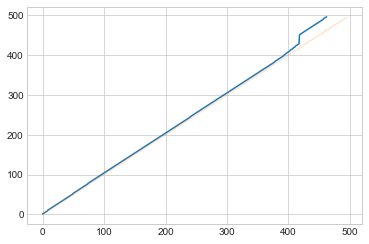

In [40]:
plt.plot(data_id_set)
plt.plot(list(range(np.max(data_id_set))),alpha=.2);

Ok, some ID where reserved, maybe for a location not yet deployed. Anyway.

#### Let's examine the regression results

In [41]:
v_min = 90
R2_high_sum = np.sum(R2 > v_min)
f"{R2_high_sum} ({R2_high_sum/len(R2)*100:.1f} % of total) park stations have R2 greater than {v_min} %"

'447 (96.5 % of total) park stations have R2 greater than 90 %'

But that statement is not so charming, some coef. of determination $R^2$ needed more than 6 dimensions to achive such good results.

But in general I am **satisfied with the results**, most of parkings we could discover which main factors influence the bikes availability, and these are in most cases less than 5 variables, in this order:  ``humidity``,  ``clouds``, ``slots``, ``hour`` and  ``ºC`` (temperature).

#### The tough to study guys

Lets study the ones, that not even using all the dimensions could calculate a regression

In [42]:
mask_R2 = R2<=0
mask_R2 = np.where(mask_R2)[0] # np.where() makes a list of indexes of Trues
park_station_arr = data_id_set[mask_R2] 
for i,k in enumerate(park_station_arr):
    print(f"park station {k:3d} has a R2 of {R2[mask_R2[i]]:.1f} %")
for k in park_station_arr:
    R2_study(data, data_id_set=[k], iterate_bool=False);

park station  43 has a R2 of 0.0 %
park station 257 has a R2 of 0.0 %
park station 290 has a R2 of 0.0 %
park station 293 has a R2 of 0.0 %
park station 355 has a R2 of 0.0 %
park station 357 has a R2 of 0.0 %


Ok, zero is assigned to $R^2$ in ``R2_study()`` to those park stations which have not bikes at all. Let's plot it to corroborate, and by the way check if there are anyway slots.

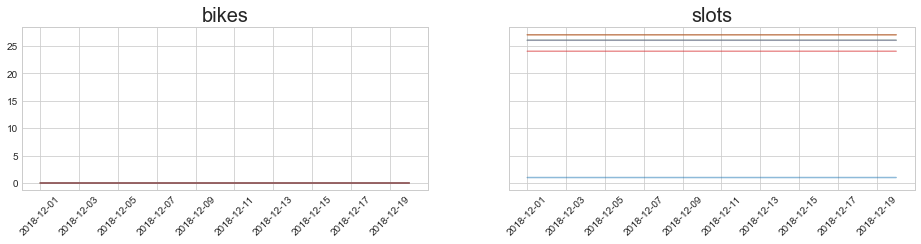

In [43]:
fig, ax = plt.subplots(1, 2,  sharey=True, figsize=(16,3))
for k in park_station_arr:
    ax[0].plot(data[data['id']==k]["bikes"], alpha=.5)
    ax[1].plot(data[data['id']==k]["slots"], alpha=.5)
ax[0].set_title("bikes", fontsize=20)
ax[1].set_title("slots", fontsize=20)
for k in ax: k.tick_params(axis='x', labelrotation=45)

#### Back to study all park stations combined  (and not isolated)

If we use $id$ as a variable. ``id`` (column 1) identifies each parking lot with a number, and obviously it is a categorical variable that we should have applied ``pd.get_dummies``.

In [44]:
len(list(set(data['id'])))

463

463 there are many columns to add, but even so I leave indicated the commands to apply:

In [45]:
if False:
    XdC_id_dummies = XdC.copy();
    XdC_id_dummies = XdC_id_dummies.join(pd.get_dummies(XdC['id']))
    XdC_id_dummies.drop(columns=['id'], inplace=True);

    print('Variables: ',XdC_id_dummies.columns)
    print(XdC_id_dummies.head())

    try:
        X = XdC_id_dummies.values
        cumuExplVariance(X);
    except Exception as e: print('Error type: ',e.__class__.__name__)